In [1]:
import os
current_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
os.chdir(current_dir)

# 데이터 불러오기

In [2]:
import numpy as np

filename = 'data/helical_real_PET_data.bin'


try:
    with open(filename, 'rb') as fid:
        LORs = np.fromfile(fid, dtype=np.float32)    # read the file as float
except FileNotFoundError:
    print(f"Incorrect listmode filename: {filename}")
    exit()

nf = 8
LORs = LORs.reshape((-1, nf)).T

# 데이터 가공

In [3]:
k = 3

knot_space = 30
tc1, tc2 = 0, 600

indices = np.argsort(LORs[3, :])
LORs = LORs[:, indices]

# P & v
P1 = LORs[0:3, :]
P2 = LORs[4:7, :]
times = LORs[3, :]

v = P2 - P1
norms = np.linalg.norm(v, axis=0)
v = v / norms


# knots
N = int(np.round(times.size / knot_space)) + 1
T = list(np.linspace(tc1, tc2, np.maximum(2, N + 1 - k)))    
knots = np.r_[[0]*k, T, [T[-1]]*k] 


# initialize
a0 = np.zeros((3, N)) 

# 최적화

In [4]:
import timeit
import matplotlib.pyplot as plt

In [5]:
lambda0 = 0.005
dmax1 = 30
dmax2 = 7

### Backpropagation

In [6]:
from commons.optimizers import single_cellGPS

In [7]:
LORs = LORs.T
start_time = timeit.default_timer()

a = single_cellGPS(a0, LORs, N, k, knots, lambda0, dmax1, options={'maxiter': 2000, 'disp': True})

mid_time = timeit.default_timer()
print(f"\n1) 실행 시간: {mid_time - start_time}초\n")

a = single_cellGPS(a, LORs, N, k, knots, lambda0, dmax2, options={'maxiter': 2000, 'disp': True})

print(f"2) 실행 시간: {timeit.default_timer() - mid_time}초")

Optimization terminated successfully.
         Current function value: 679.103780
         Iterations: 398
         Function evaluations: 410
         Gradient evaluations: 410

1) 실행 시간: 0.3977854000404477초

Optimization terminated successfully.
         Current function value: 45.696604
         Iterations: 390
         Function evaluations: 410
         Gradient evaluations: 410
2) 실행 시간: 0.37654629989992827초


### Numerical Gradient

In [8]:
from scipy.optimize import minimize
from commons.loss import objf3D
import timeit

In [9]:
start_time = timeit.default_timer()


S0 = a0.copy()
options = {'maxiter': 2000, 'disp': True}
result = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax1, lambda0), S0, method='BFGS')
X0 = result.x


mid_time = timeit.default_timer()
print(f"\n1) 실행 시간: {mid_time - start_time}초\n")


result2 = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax2, lambda0), X0, method='BFGS')
b = result2.x


print(f"2) 실행 시간: {timeit.default_timer() - mid_time}초")

C:\Users\Programming\AppData\Local\Temp\ipykernel_7240\3202628083.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax1, lambda0), S0, method='BFGS')



1) 실행 시간: 98.0328487000661초

2) 실행 시간: 67.88074009993579초


# Plotting

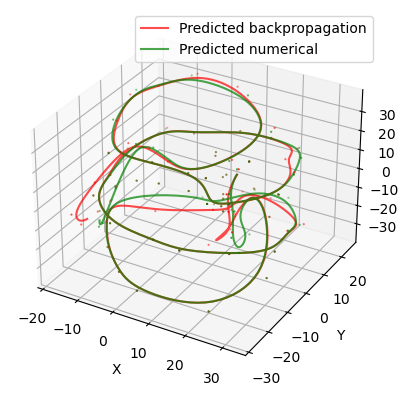

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline


# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot the spline
for i in range(2):
    X = [a, b][i]
    color = ['red', 'green'][i]
    name = ['backpropagation', 'numerical'][i]

    # Control points
    X = X.reshape((3, -1))
    s_x = X[0,]
    s_y = X[1,]
    s_z = X[2,]

    # Plot the control points
    ax.scatter(s_x, s_y, s_z, color=color, s=0.3)

    # Predict timess
    tm1, tm2 = 100, 590
    Nr = 500
    te = np.linspace(tm1, tm2, Nr)

    # Create B-spline and Predictions
    spl_x = BSpline(knots, s_x, k)
    spl_y = BSpline(knots, s_y, k)
    spl_z = BSpline(knots, s_z, k)
    x_predict = spl_x(te)
    y_predict = spl_y(te)
    z_predict = spl_z(te)

    ax.plot(x_predict, y_predict, z_predict, color=color, label=f'Predicted {name}', alpha=0.7)

# Display the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()